<a href="https://colab.research.google.com/github/gavindoughtie/pytorch_class/blob/main/udemy_pytorch_03_01_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision

* See reference ntebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/video_notebooks/03_pytorch_computer_vision_video.ipynb
* See reference online book - https://www.learnpytorch.io/03_pytorch_computer_vision/

## 0. Computer vision libraries in PyTorch

* `torchvision` - base domain library for computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transoforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchivsion
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Check versions
print(torch.__version__)
print(torchvision.__version__)
print(f'device: {device}')

1.13.0+cu116
0.14.0+cu116
device: cuda


## 1. Getting a dataset

The dataset we'll be using is FashionMNIST, which is like the MNIST letter dataset, but with articles of clothing and a little bit harder.

In [2]:
# Setup training data

train_data = datasets.FashionMNIST(
    root='data', # where to download data to
    train=True, # get the training dataset rather than testing
    download=True, # do we want to download?
    transform=ToTensor(), # Convert to tensor straight away
    target_transform=None # Do not want to transform the targets (labels)
)

test_data = datasets.FashionMNIST(
    root='data', # where to download data to
    train=False, # get the training dataset rather than testing
    download=True, # do we want to download?
    transform=ToTensor(), # Convert to tensor straight away
    target_transform=None # Do not want to transform the targets (labels)
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
class_to_idx = train_data.class_to_idx
class_to_idx, class_names[9]

({'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9},
 'Ankle boot')

In [6]:
train_data.targets[:10]
image, label = train_data[0]

In [7]:
# Check the shape of our image
print(f'Image shape: {image.shape} -> [color_channels, height, width]')
print(f'Image label: "{class_names[label]}"')

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: "Ankle boot"


### 1.2 Visualize our data

image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

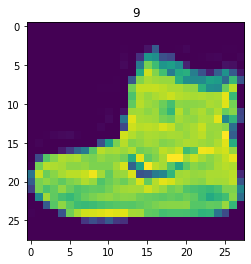

In [8]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f'image shape: {image.shape}')
plt.imshow(image.squeeze())
plt.title(label)

(-0.5, 27.5, 27.5, -0.5)

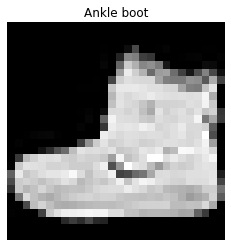

In [9]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)

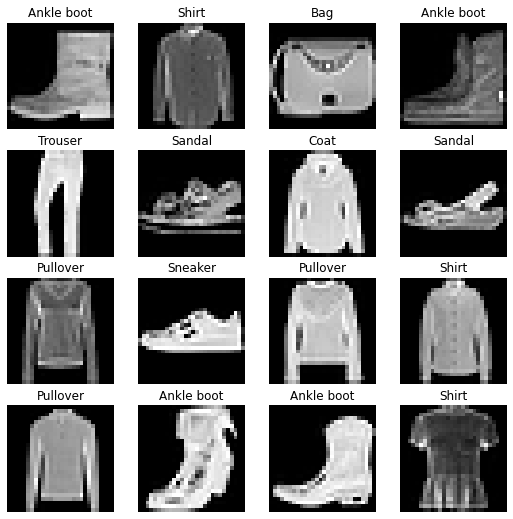

In [10]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

Do you think these items of clothing (images) could be modeled with pure linear lines, or do you think we need non-linearities? (Hint: *I* sure do)

In [11]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [12]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## 2. Prepare DataLoader

Right now our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (minibatches).

Why?

1. It is more computationally efficient, as in your computing hardware may not be able to look (store in memory) 60K images in one hit. So we break it down to a small number (often 32) or images at a time.
2. It gives our neural network more chances to update its gradients per epoch.

For more on minibatches, go back to Andy Ng!

In [13]:
from torch.utils.data import DataLoader

# setup batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fb5f279b0a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb5f279b160>)

In [14]:
# Let's check out what we've created
print(f'DataLoaders: {train_dataloader, test_dataloader}')
print(f'len of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...')
print(f'len of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...')

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fb5f279b0a0>, <torch.utils.data.dataloader.DataLoader object at 0x7fb5f279b160>)
len of train_dataloader: 1875 batches of 32...
len of test_dataloader: 313 batches of 32...


In [15]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

image size: torch.Size([1, 28, 28])
label: 6, label size: torch.Size([])


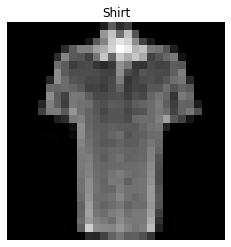

In [16]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f'image size: {img.shape}')
print(f'label: {label}, label size: {label.shape}')

## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try to improve upon with subsequent models/experiments.

In other worders, start simply and add complexity when necessary (try to avoid starting out overfitting!)

In [17]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]
print(f'starting shape: {x.shape}')

# flatten the sample
output = flatten_model(x)
print(f'output after flattening: {output.shape}')


starting shape: torch.Size([1, 28, 28])
output after flattening: torch.Size([1, 784])


In [18]:
1*28*28

784

In [19]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)

model_0 = FashionMNISTModelV0(
    input_shape=output.shape[1],
    hidden_units=10,
    output_shape=len(class_names)).to(device)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [20]:
# use a dummy input to validate that model shapes are correct
dummy_x = torch.rand([1, 1, 28, 28]).to(device)
model_0(dummy_x)

tensor([[ 0.4283,  0.1136, -0.3903, -0.0246, -0.0698,  0.2508,  0.4007, -0.4172,
         -0.0264, -0.2463]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 3.1 Setup loss, optimizer and evaulation metrics

* Loss function - since we're working with multiclass data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer will start with `torch.optim.SGD()` (stochastic gradient descent)
* Evaluation metric - since we're working on classification, let's use accuracy as evaluation metric.

In [21]:
import requests
from pathlib import Path

# Download helper functions
if Path('helper_functions.py').is_file():
  print(f'helper_functions.py exists, skipping download...')
else:
  print(f'downloading helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

downloading helper_functions.py


In [22]:
from helper_functions import accuracy_fn

# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

### 3.2 Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values)
2. How fast it runs

In [23]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f'Train time on {device}: {total_time:.3f} seconds')
  return total_time

In [24]:
start_time = timer()
# some code
p = model_0(dummy_x)
end_time = timer()
print_train_time(start=start_time, end=end_time, device=device)

Train time on cuda: 0.002 seconds


0.001667982999947526

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all

In [25]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()
device=next(model_0.parameters()).device
# set the number of epochs (keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n------')
  ### Training
  train_loss = 0
  # Add a loop to loop through training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    X = X.to(device)
    y = y.to(device)
    # 1. Forward pass
    y_pred = model_0(X)

    # 2. Calculate loss per batch
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulated loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backprop
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # print out what's happening
    if batch % 400 == 0:
      print(f'looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.')

  # get the per-epoch training loss
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      X_test = X_test.to(device)
      y_test = y_test.to(device)
      # forward pass
      test_pred = model_0(X_test)
      # calculate loss
      test_loss += loss_fn(test_pred, y_test)
      # calcualte accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
    # calculate test loss average per batch
    test_loss /= len(test_dataloader) # len(test_dataloader) gives batch count
    # calculate test acc average per batch
    test_acc /= len(test_dataloader)

  # print out what's happening
  print(f'\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}')

# calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
looked at 0/60000 samples.
looked at 12800/60000 samples.
looked at 25600/60000 samples.
looked at 38400/60000 samples.
looked at 51200/60000 samples.

Train loss: 0.5948 | Test loss: 0.5164, Test acc: 81.8391
Epoch: 1
------
looked at 0/60000 samples.
looked at 12800/60000 samples.
looked at 25600/60000 samples.
looked at 38400/60000 samples.
looked at 51200/60000 samples.

Train loss: 0.4795 | Test loss: 0.4814, Test acc: 83.1769
Epoch: 2
------
looked at 0/60000 samples.
looked at 12800/60000 samples.
looked at 25600/60000 samples.
looked at 38400/60000 samples.
looked at 51200/60000 samples.

Train loss: 0.4570 | Test loss: 0.4777, Test acc: 83.4964
Train time on cuda:0: 22.677 seconds


## 4. Make predictions and get Model 0 results

In [26]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=None):
  """Returns a dictionary containing the results of model predicting on data loader"""
  loss, acc = 0, 0
  if not device:
    device = next(model.parameters()).device

  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X = X.to(device)
      y = y.to(device)
      # make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    # scall the loss and acc to find average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {
      'model_name': model.__class__.__name__, # only works when model was created with a class
      'model_loss': loss.item(),
      'model_acc': acc
  }

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4777320623397827,
 'model_acc': 83.49640575079871}

In [27]:
# already set up as device-agnostic code, so didn't bother with that section

## 6. Model 1 - building a better model with nonlinearity

In [28]:
# Fancier example
def train_step(model: nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer, 
               accuracy_fn,
               device: torch.device=None):
  """Performs a training step with model trying to learn on data_learner."""
  if not device:
    device = next(model.parameters()).device

  train_loss, train_acc = 0, 0

  # put model into training ode
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    # put data on target devie:
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss per batch
    loss = loss_fn(y_pred, y)

    # accumulate losses
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backprop
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  print(f'train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f}%')
  return (train_loss, train_acc)

In [29]:
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device=None):
  """Evaluates results of model trained on dataloader"""
  if not device:
    device = next(model.parameters()).device

  test_loss, test_acc = 0, 0

  # put model into training ode
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      # put data on target devie:
      X, y = X.to(device), y.to(device)
      # forward pass
      test_pred = model(X)
      # calculate loss
      test_loss += loss_fn(test_pred, y)
      # calculate accuracy
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    print(f'test_loss {test_loss:.5f}, test_acc: {test_acc:.2f}%')
    return (test_loss, test_acc)


In [30]:
from torch import nn

class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)

model_1 = FashionMNISTModelV1(
    input_shape=output.shape[1],
    hidden_units=10,
    output_shape=len(class_names)).to(device)

model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [31]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.1
)


# set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()
device=next(model_1.parameters()).device
# set the number of epochs (keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n------')
  train_step(model_1, train_dataloader, loss_fn, optimizer, accuracy_fn, device=device)
  test_step(model_1, test_dataloader, loss_fn, accuracy_fn, device=device)

# calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
train_loss: 1.11456, train_acc: 58.46%
test_loss 0.96320, test_acc: 63.41%
Epoch: 1
------
train_loss: 0.90905, train_acc: 64.87%
test_loss 0.74544, test_acc: 72.61%
Epoch: 2
------
train_loss: 0.59508, train_acc: 78.25%
test_loss 0.49708, test_acc: 82.77%
Train time on cuda:0: 23.552 seconds


In [47]:
# Calculate model 1 results on test dataset
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4540885388851166,
 'model_acc': 83.88578274760384}

### 6.2 Functionizing training and evalulation loops

(done above)

In [33]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.1
)


# set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()
device=next(model_1.parameters()).device
# set the number of epochs (keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n------')
  train_step(model_1, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model_1, test_dataloader, loss_fn, accuracy_fn, device)

# calculate training time
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device=device)

model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
train_loss: 0.43760, train_acc: 84.42%
test_loss 0.46516, test_acc: 83.34%
Epoch: 1
------
train_loss: 0.42230, train_acc: 84.85%
test_loss 0.47283, test_acc: 83.44%
Epoch: 2
------
train_loss: 0.41345, train_acc: 85.17%
test_loss 0.45409, test_acc: 83.89%
Train time on cuda:0: 23.422 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4540885388851166,
 'model_acc': 83.88578274760384}

**Note:** Sometimes, depending on data/hardware you might find that CPU is faster than GPU. 

1. The overhead of GPU I/O can overwhelm the computational advantage.
2. You have a better CPU than GPU! (not usually)

See https://horace.io/brrr_intro.html

## Model 2: Building a convolutional neural network (CNN)

* Also known as Convnets
* Known for their ability to find patterns in image data

https://poloclub.github.io/cnn-explainer

In [34]:
# Create a convolutional neural network
import torch
from torch import nn

class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website.
  """
  def __init__(self, 
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1), # set some common hyperparameters
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1), # set some common hyperparameters
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # todo - trick to calculating this
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

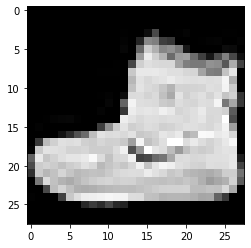

In [35]:
plt.imshow(image.squeeze(), cmap='gray')

In [36]:
# pass image through model
# model_2(image) # SHAPE ERROR
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [37]:
# pass image through model
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 7.1 Stepping through `nn.Conv2d()`

See documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [38]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]
print(f'Image batch shape: {images.shape}')
print(f'Single image shape: {test_image.shape}')
print(f'Test image:\n{test_image}')

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.

In [39]:
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

# pass the data through the convolutional layer
conv_output = conv_layer(test_image)
# note the output shape is smaller because the convolution swallows
# the edge pixels
test_image.shape, conv_output.shape

(torch.Size([3, 64, 64]), torch.Size([10, 62, 62]))

### 7.2 Stepping through `nn.MaxPool2d()`

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool2d#torch.nn.MaxPool2d

In [40]:
test_image.shape

torch.Size([3, 64, 64])

In [41]:
# Print out original image shape
print(f'Test image original shape: {test_image.shape}')
print(f'Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}')

# Create a sample nn.MaxPool2d layer
# max pool takes the largest value in the convolution kernel
max_pool_layer = nn.MaxPool2d(kernel_size=2) # 2x2 convolution

# pass data through just the conv layer
test_image_through_conv=conv_layer(test_image.unsqueeze(dim=0))
print(f'Shape after conv_layer: {test_image_through_conv.shape}')

# pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f'Shape after conv_layer and max pool layer: {test_image_through_conv_and_max_pool.shape}')

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after conv_layer: torch.Size([1, 10, 62, 62])
Shape after conv_layer and max pool layer: torch.Size([1, 10, 31, 31])


In [42]:
torch.manual_seed(42)

# max pool intuition
# Create a random tensor with a similar number of dimensions
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f'random_tensor:\n{random_tensor}')
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# pass random tensor through max pool layer
max_pool_tensor = max_pool_layer(random_tensor)

print(f'\nMax pool tensor:\n{max_pool_tensor}')
print(f'\nMax pool tensor.shape:\n{max_pool_tensor.shape}')

random_tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])

Max pool tensor:
tensor([[[[0.3367]]]])

Max pool tensor.shape:
torch.Size([1, 1, 1, 1])


### 7.3 Setup a loss function and optimizer for `model_2`

In [43]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Create a conv layer - https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        nn.Conv2d(in_channels=input_shape, 
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1), # values we can set ourselves in our NN's are called hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # there's a trick to calculating this...
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x) 
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x

In [44]:
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [45]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn


loss_fn = nn.CrossEntropyLoss()
optimizier = torch.optim.Adam(params=model_2.parameters(), lr=0.1)

### 7.4 Traing and testing `model_2` using our training and test functions

In [46]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

device=next(model_1.parameters()).device
# set the number of epochs (keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n------')
  train_step(model_2, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model_2, test_dataloader, loss_fn, accuracy_fn, device)

# calculate training time
train_time_end_on_gpu = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device=device)

model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_2_results

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
train_loss: 2.30334, train_acc: 10.21%
test_loss 2.30333, test_acc: 10.19%
Epoch: 1
------
train_loss: 2.30334, train_acc: 10.21%
test_loss 2.30333, test_acc: 10.19%
Epoch: 2
------
train_loss: 2.30334, train_acc: 10.21%
test_loss 2.30333, test_acc: 10.19%
Train time on cuda:0: 31.456 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 2.303330898284912,
 'model_acc': 10.193690095846645}